In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import matplotlib.pyplot as plt
import seaborn as sns

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/data-storm-6-0/sample_submission_storming_round.csv
/kaggle/input/data-storm-6-0/train_storming_round.csv
/kaggle/input/data-storm-6-0/test_storming_round.csv


In [2]:
df = pd.read_csv('/kaggle/input/data-storm-6-0/train_storming_round.csv')
test = pd.read_csv('/kaggle/input/data-storm-6-0/test_storming_round.csv')
submission = pd.read_csv('/kaggle/input/data-storm-6-0/sample_submission_storming_round.csv')

# Optimize

In [3]:
# Optimize integer columns (check value ranges first)
def optimize(df):
    int_columns = df.select_dtypes(include=['int64']).columns
    
    for col in int_columns:
        col_min = df[col].min()
        col_max = df[col].max()
        if col_min >= 0:
            if col_max < 255:
                df[col] = df[col].astype(np.uint8)
            elif col_max < 65535:
                df[col] = df[col].astype(np.uint16)
            elif col_max < 4294967295:
                df[col] = df[col].astype(np.uint32)
        else:
            if np.iinfo(np.int8).min <= col_min <= np.iinfo(np.int8).max:
                df[col] = df[col].astype(np.int8)
            elif np.iinfo(np.int16).min <= col_min <= np.iinfo(np.int16).max:
                df[col] = df[col].astype(np.int16)
            elif np.iinfo(np.int32).min <= col_min <= np.iinfo(np.int32).max:
                df[col] = df[col].astype(np.int32)
    
    # Convert datetime fields
    df['agent_join_month'] = pd.to_datetime(df['agent_join_month'], format='%m/%d/%Y')
    df['first_policy_sold_month'] = pd.to_datetime(df['first_policy_sold_month'], format='%m/%d/%Y')
    df['year_month'] = pd.to_datetime(df['year_month'], format='%m/%d/%Y')

    return df

df = optimize(df)
test = optimize(test)

# Extract New Features

In [4]:
df.columns

Index(['row_id', 'agent_code', 'agent_age', 'agent_join_month',
       'first_policy_sold_month', 'year_month', 'unique_proposals_last_7_days',
       'unique_proposals_last_15_days', 'unique_proposals_last_21_days',
       'unique_proposal', 'unique_quotations_last_7_days',
       'unique_quotations_last_15_days', 'unique_quotations_last_21_days',
       'unique_quotations', 'unique_customers_last_7_days',
       'unique_customers_last_15_days', 'unique_customers_last_21_days',
       'unique_customers', 'new_policy_count', 'ANBP_value', 'net_income',
       'number_of_policy_holders', 'number_of_cash_payment_policies'],
      dtype='object')

In [5]:
def feature_eng(df):
    # Extract year and month from agent join date
    df['agent_join_year'] = df['agent_join_month'].dt.year
    df['agent_join_month_num'] = df['agent_join_month'].dt.month
    
    # Extract year and month from first policy sold date
    df['first_policy_year'] = df['first_policy_sold_month'].dt.year
    df['first_policy_month_num'] = df['first_policy_sold_month'].dt.month
    
    # Extract year and month from the year_month column
    df['record_year'] = df['year_month'].dt.year
    df['record_month'] = df['year_month'].dt.month
    
    # 1. Conversion Rate Features
    df['proposal_to_policy_ratio'] = df['unique_proposal'] / df['new_policy_count'].replace(0, 1)
    df['quotation_to_policy_ratio'] = df['unique_quotations'] / df['new_policy_count'].replace(0, 1)
    df['customer_to_policy_ratio'] = df['unique_customers'] / df['new_policy_count'].replace(0, 1)
    df['proposal_to_quotation_ratio'] = df['unique_quotations'] / df['unique_proposal'].replace(0, 1)
    df['quotation_to_customer_ratio'] = df['unique_customers'] / df['unique_quotations'].replace(0, 1)
    
    # 2. Time-Based Features
    # Calculate how many months since agent joined
    df['months_since_join'] = ((df['year_month'].dt.year - df['agent_join_month'].dt.year) * 12 +
                               (df['year_month'].dt.month - df['agent_join_month'].dt.month))
    
    # Calculate how long it took for agent to sell first policy
    df['months_to_first_sale'] = ((df['first_policy_sold_month'].dt.year - df['agent_join_month'].dt.year) * 12 +
                                  (df['first_policy_sold_month'].dt.month - df['agent_join_month'].dt.month))
    df['months_since_first_sale'] = (df['year_month'] - df['first_policy_sold_month']).dt.days / 30
    
    # 3. Activity Trend Features
    df['recent_proposal_ratio'] = df['unique_proposals_last_7_days'] / df['unique_proposal'].replace(0, 1)
    df['recent_quotation_ratio'] = df['unique_quotations_last_7_days'] / df['unique_quotations'].replace(0, 1)
    df['recent_customer_ratio'] = df['unique_customers_last_7_days'] / df['unique_customers'].replace(0, 1)
    
    # 4. Productivity Features
    df['ANBP_per_policy'] = df['ANBP_value'] / df['new_policy_count'].replace(0, 1)
    df['income_per_policy'] = df['net_income'] / df['new_policy_count'].replace(0, 1)
    df['income_per_customer'] = df['net_income'] / df['unique_customers'].replace(0, 1)
    df['cash_payment_ratio'] = df['number_of_cash_payment_policies'] / df['new_policy_count'].replace(0, 1)

    # New combined features based on high MI score variables
    df['cash_policy_to_proposal_ratio'] = df['number_of_cash_payment_policies'] / df['unique_proposal'].replace(0, np.nan)
    df['ANBP_per_proposal'] = df['ANBP_value'] / df['unique_proposal'].replace(0, np.nan)
    df['ANBP_per_cash_policy'] = df['ANBP_value'] / df['number_of_cash_payment_policies'].replace(0, np.nan)
    
    # Create a feature combining top factors
    df['top_feature_combo'] = (
        df['number_of_cash_payment_policies'] * 
        df['unique_proposal'] * 
        df['ANBP_value'] / 
        (df['unique_proposal'] + 1)
    )
    
    # Net income appears relevant
    if 'net_income' in df.columns:
        df['income_per_proposal'] = df['net_income'] / df['unique_proposal'].replace(0, np.nan)
        df['income_per_cash_policy'] = df['net_income'] / df['number_of_cash_payment_policies'].replace(0, np.nan)
    
    # Only include agent features with some signal
    if 'agent_code' in df.columns and 'new_policy_count' in df.columns:
        # Average monthly sales (the alt version had slightly higher MI)
        agent_monthly_avg = (
            df.groupby('agent_code')['new_policy_count']
            .mean()
            .reset_index(name='avg_monthly_sales')
        )
        agent_monthly_avg_dict = dict(zip(agent_monthly_avg['agent_code'], agent_monthly_avg['avg_monthly_sales']))
        df['agent_avg_monthly_sales_alt'] = df['agent_code'].map(agent_monthly_avg_dict)

    # Fill NaN values with 0 or another appropriate value
    df = df.fillna(0)
    
    return df

df = feature_eng(df)
test = feature_eng(test)

In [6]:
df.columns

Index(['row_id', 'agent_code', 'agent_age', 'agent_join_month',
       'first_policy_sold_month', 'year_month', 'unique_proposals_last_7_days',
       'unique_proposals_last_15_days', 'unique_proposals_last_21_days',
       'unique_proposal', 'unique_quotations_last_7_days',
       'unique_quotations_last_15_days', 'unique_quotations_last_21_days',
       'unique_quotations', 'unique_customers_last_7_days',
       'unique_customers_last_15_days', 'unique_customers_last_21_days',
       'unique_customers', 'new_policy_count', 'ANBP_value', 'net_income',
       'number_of_policy_holders', 'number_of_cash_payment_policies',
       'agent_join_year', 'agent_join_month_num', 'first_policy_year',
       'first_policy_month_num', 'record_year', 'record_month',
       'proposal_to_policy_ratio', 'quotation_to_policy_ratio',
       'customer_to_policy_ratio', 'proposal_to_quotation_ratio',
       'quotation_to_customer_ratio', 'months_since_join',
       'months_to_first_sale', 'months_since_fi

# Categorize Agents by Performance

## 1. Quantile Based on Total Sales

Use total sales per agent over all time to assign categories using percentiles.

Pros:
- Simple and fast.
- Reflects long-term performance.

Cons:
- Doesn’t account for how recent agents joined.
- Biased if agent is new or inactive for long time.

/usr/local/lib/python3.11/dist-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/usr/local/lib/python3.11/dist-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/usr/local/lib/python3.11/dist-packages/seaborn/_oldcore.py:1075: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  data_subset = grouped_data.get_group(pd_key)
/usr/local/lib/python3.11/dist-packages/seaborn/_oldcore.py:1075: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to 

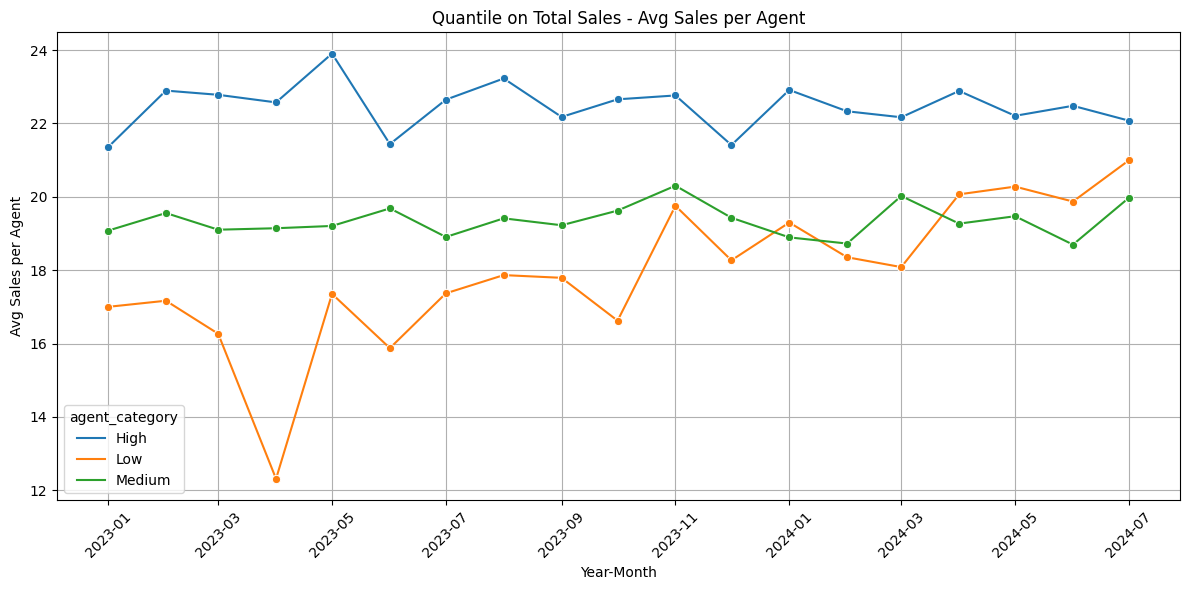

In [7]:
# Total sales per agent
total_sales = df.groupby('agent_code')['new_policy_count'].sum()

# Define quantile thresholds
high_thresh = total_sales.quantile(0.75)
low_thresh = total_sales.quantile(0.25)

# Categorize agents
def categorize_total(sales):
    if sales >= high_thresh:
        return 'High'
    elif sales <= low_thresh:
        return 'Low'
    else:
        return 'Medium'

# Fix here
agent_category = total_sales.apply(categorize_total)
agent_category = agent_category.to_frame(name='agent_category').reset_index()

# Merge back
df1 = df.merge(agent_category, on='agent_code')

# Plot avg sales per agent
filtered_df1 = df1[(df1['year_month'] >= '2023-01') & (df1['year_month'] <= '2024-07')]
monthly_sales = filtered_df1.groupby(['year_month', 'agent_category']).agg(
    total_sales=('new_policy_count', 'sum'),
    agent_count=('agent_code', 'nunique')
).reset_index()
monthly_sales['avg_sales_per_agent'] = monthly_sales['total_sales'] / monthly_sales['agent_count']

# Plot
plt.figure(figsize=(12, 6))
sns.lineplot(data=monthly_sales, x='year_month', y='avg_sales_per_agent', hue='agent_category', marker='o')
plt.title('Quantile on Total Sales - Avg Sales per Agent')
plt.xlabel('Year-Month')
plt.ylabel('Avg Sales per Agent')
plt.xticks(rotation=45)
plt.grid(True)
plt.tight_layout()
plt.show()


In [8]:
# Calculate the descriptive statistics
descriptive_stats = df1.groupby('agent_category')[['new_policy_count', 'ANBP_value', 'net_income']].describe().round(2)

# Calculate the unique agent counts per category
agent_counts = df1[['agent_code', 'agent_category']].drop_duplicates()
agent_count_series = agent_counts['agent_category'].value_counts().rename('agent_count')

# Merge the agent counts into the descriptive statistics table
descriptive_stats = pd.concat([descriptive_stats, agent_count_series], axis=1)

descriptive_stats

,"(new_policy_count, count)","(new_policy_count, mean)","(new_policy_count, std)","(new_policy_count, min)","(new_policy_count, 25%)","(new_policy_count, 50%)","(new_policy_count, 75%)","(new_policy_count, max)","(ANBP_value, count)","(ANBP_value, mean)",...,"(ANBP_value, max)","(net_income, count)","(net_income, mean)","(net_income, std)","(net_income, min)","(net_income, 25%)","(net_income, 50%)","(net_income, 75%)","(net_income, max)",agent_count
agent_category,,,,,,,,,,,,,,,,,,,,,
High,4537.0,22.50,8.77,0.0,17.0,24.0,29.0,42.0,4537.0,1149116.12,...,3933840.0,4537.0,242981.45,179586.30,2011.0,103687.00,203551.0,344621.00,1061261.0,227
Low,1868.0,19.13,9.74,0.0,14.0,20.0,26.0,39.0,1868.0,966045.85,...,3658830.0,1868.0,221690.85,169099.26,2474.0,87985.75,186025.5,313208.75,1008836.0,227
Medium,8903.0,19.37,9.69,0.0,14.0,20.0,26.0,42.0,8903.0,974700.37,...,3892400.0,8903.0,221760.34,171079.75,1160.0,89043.00,183447.0,312656.00,1140237.0,451


In [9]:
from scipy.stats import f_oneway

for feature in ['new_policy_count', 'ANBP_value', 'net_income']:
    groups = [g[feature].dropna().values for name, g in df1.groupby('agent_category')]
    f_stat, p_val = f_oneway(*groups)
    print(f"{feature} ANOVA → F={f_stat:.2f}, p={p_val:.4f}")


new_policy_count ANOVA → F=180.94, p=0.0000
ANBP_value ANOVA → F=76.98, p=0.0000
net_income ANOVA → F=23.93, p=0.0000


## 2. Quantile Based on Average Monthly Sales (Overall Category Plot)

Use total monthly sales per category to classify performance at group level.

Pros:
- More fair for newly joined agents.
- Smooths fluctuations.

Cons:
- Sensitive to outliers.
- Misses long-term accumulation.

/usr/local/lib/python3.11/dist-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/usr/local/lib/python3.11/dist-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/usr/local/lib/python3.11/dist-packages/seaborn/_oldcore.py:1075: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  data_subset = grouped_data.get_group(pd_key)
/usr/local/lib/python3.11/dist-packages/seaborn/_oldcore.py:1075: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to 

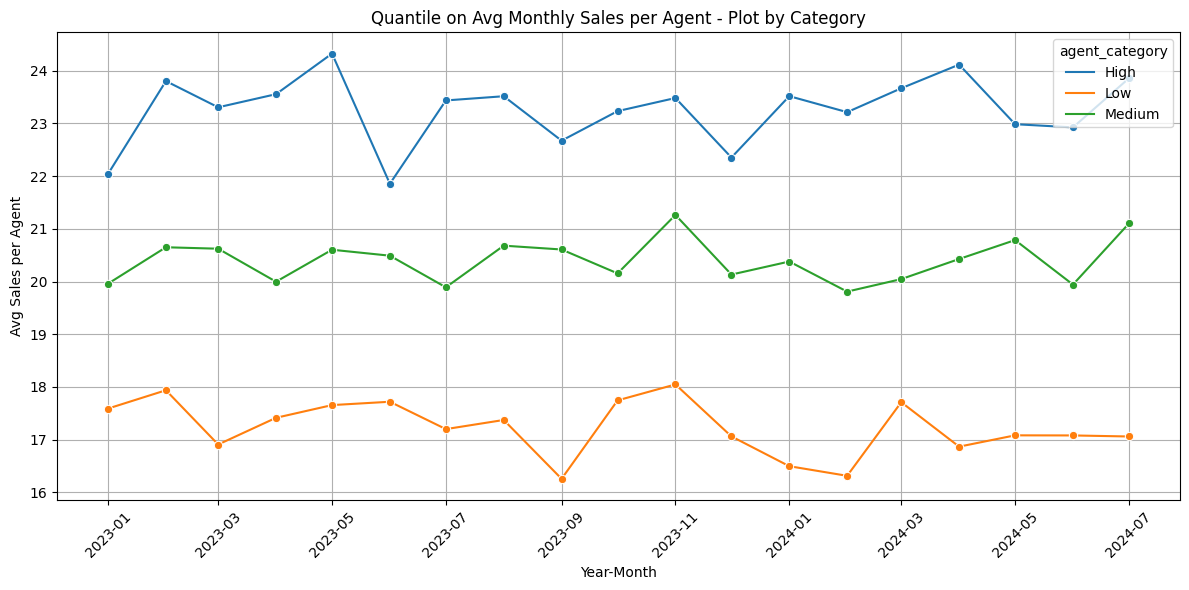

In [10]:
# Filter data
filtered_df = df[(df['year_month'] >= '2023-01') & (df['year_month'] <= '2024-07')]

# Sum by agent
agent_monthly_avg = (
    filtered_df.groupby('agent_code')['new_policy_count']
    .mean()
    .reset_index(name='avg_monthly_sales')
)

# Quantiles
high_thresh = agent_monthly_avg['avg_monthly_sales'].quantile(0.75)
low_thresh = agent_monthly_avg['avg_monthly_sales'].quantile(0.25)

def categorize_avg_monthly(sales):
    if sales >= high_thresh:
        return 'High'
    elif sales <= low_thresh:
        return 'Low'
    else:
        return 'Medium'

agent_monthly_avg['agent_category'] = agent_monthly_avg['avg_monthly_sales'].apply(categorize_avg_monthly)
df2 = df.merge(agent_monthly_avg[['agent_code', 'agent_category']], on='agent_code')

# Plotting
filtered_df2 = df2[(df2['year_month'] >= '2023-01') & (df2['year_month'] <= '2024-07')]
monthly_sales = filtered_df2.groupby(['year_month', 'agent_category']).agg(
    total_sales=('new_policy_count', 'sum'),
    agent_count=('agent_code', 'nunique')
).reset_index()
monthly_sales['avg_sales_per_agent'] = monthly_sales['total_sales'] / monthly_sales['agent_count']

# Plot
plt.figure(figsize=(12, 6))
sns.lineplot(data=monthly_sales, x='year_month', y='avg_sales_per_agent', hue='agent_category', marker='o')
plt.title('Quantile on Avg Monthly Sales per Agent - Plot by Category')
plt.xlabel('Year-Month')
plt.ylabel('Avg Sales per Agent')
plt.xticks(rotation=45)
plt.grid(True)
plt.tight_layout()
plt.show()


In [11]:
# Calculate the descriptive statistics as you did before
descriptive_stats = df2.groupby('agent_category')[['new_policy_count', 'ANBP_value', 'net_income']].describe().round(2)

# Calculate the unique agent counts per category
agent_counts = df2[['agent_code', 'agent_category']].drop_duplicates()
agent_count_series = agent_counts['agent_category'].value_counts().rename('agent_count')

# Merge the agent counts into the descriptive statistics table
descriptive_stats = pd.concat([descriptive_stats, agent_count_series], axis=1)

descriptive_stats

,"(new_policy_count, count)","(new_policy_count, mean)","(new_policy_count, std)","(new_policy_count, min)","(new_policy_count, 25%)","(new_policy_count, 50%)","(new_policy_count, 75%)","(new_policy_count, max)","(ANBP_value, count)","(ANBP_value, mean)",...,"(ANBP_value, max)","(net_income, count)","(net_income, mean)","(net_income, std)","(net_income, min)","(net_income, 25%)","(net_income, 50%)","(net_income, 75%)","(net_income, max)",agent_count
agent_category,,,,,,,,,,,,,,,,,,,,,
High,3450.0,23.09,8.40,0.0,18.0,24.0,29.0,42.0,3450.0,1171894.88,...,3800277.0,3450.0,244474.06,179824.23,2011.0,104806.25,207415.5,349116.5,1061261.0,223
Low,3800.0,17.47,10.18,0.0,12.0,19.0,25.0,41.0,3800.0,899010.95,...,3892400.0,3800.0,219841.05,168184.95,1812.0,90469.75,183611.5,306928.5,1140237.0,229
Medium,8045.0,20.38,9.32,0.0,15.0,21.0,27.0,42.0,8045.0,1021409.99,...,3933840.0,8045.0,224687.87,173025.37,1160.0,89080.00,185761.0,319301.0,1049253.0,440


In [12]:
from scipy.stats import f_oneway

for feature in ['new_policy_count', 'ANBP_value', 'net_income']:
    groups = [g[feature].dropna().values for name, g in df2.groupby('agent_category')]
    f_stat, p_val = f_oneway(*groups)
    print(f"{feature} ANOVA → F={f_stat:.2f}, p={p_val:.4f}")


new_policy_count ANOVA → F=327.71, p=0.0000
ANBP_value ANOVA → F=105.38, p=0.0000
net_income ANOVA → F=21.24, p=0.0000


## 3. Quantile on Agent’s Average Monthly Sales (Individual-Based Categorization)

This method computes each agent's average monthly sales (not total), then uses quantiles to categorize them.

For each agent, compute:
avg_monthly_sales = total_sales / active_months

Then apply quantiles (25%, 75%) to categorize.

/usr/local/lib/python3.11/dist-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/usr/local/lib/python3.11/dist-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/usr/local/lib/python3.11/dist-packages/seaborn/_oldcore.py:1075: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  data_subset = grouped_data.get_group(pd_key)
/usr/local/lib/python3.11/dist-packages/seaborn/_oldcore.py:1075: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to 

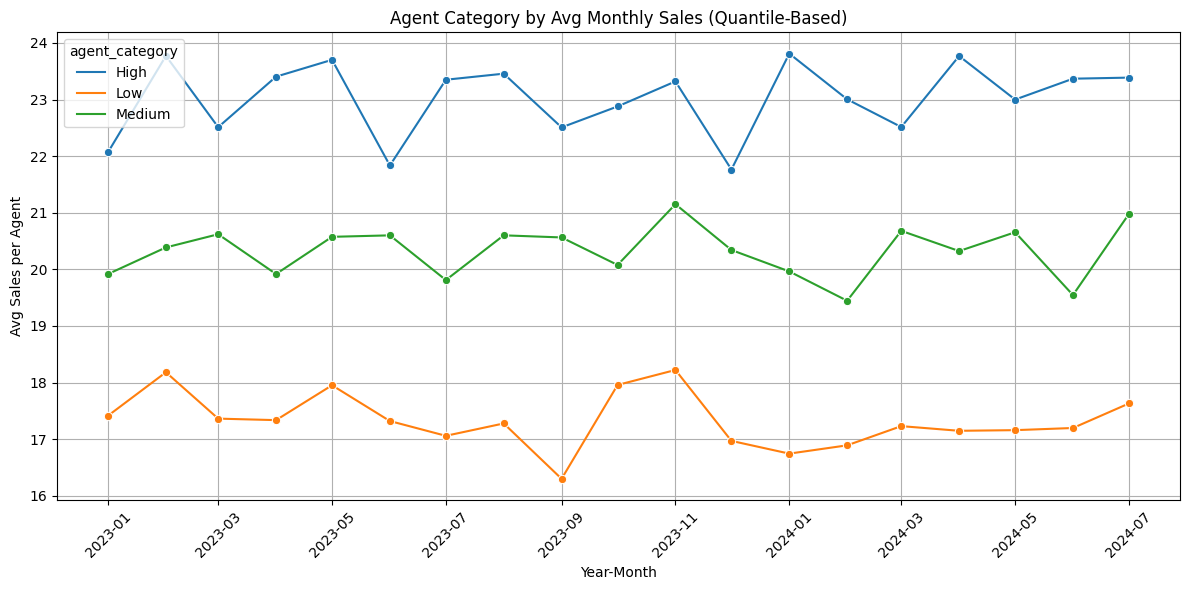

In [13]:
# Step 1: Compute total sales and active months per agent
agent_months = df.groupby('agent_code')['year_month'].nunique()
agent_sales = df.groupby('agent_code')['new_policy_count'].sum()

avg_monthly_sales = (agent_sales / agent_months).fillna(0)

# Step 2: Categorize based on quantiles
high_thresh = avg_monthly_sales.quantile(0.75)
low_thresh = avg_monthly_sales.quantile(0.25)

def categorize_avg_monthly(sales):
    if sales >= high_thresh:
        return 'High'
    elif sales <= low_thresh:
        return 'Low'
    else:
        return 'Medium'

agent_category = avg_monthly_sales.apply(categorize_avg_monthly).to_frame(name='agent_category').reset_index()

# Step 3: Merge back
df3 = df.merge(agent_category, on='agent_code')

# Step 4: Plot
filtered_df3 = df3[(df3['year_month'] >= '2023-01') & (df3['year_month'] <= '2024-07')]
monthly_sales = filtered_df3.groupby(['year_month', 'agent_category']).agg(
    total_sales=('new_policy_count', 'sum'),
    agent_count=('agent_code', 'nunique')
).reset_index()
monthly_sales['avg_sales_per_agent'] = monthly_sales['total_sales'] / monthly_sales['agent_count']

# Step 5: Plot
plt.figure(figsize=(12, 6))
sns.lineplot(data=monthly_sales, x='year_month', y='avg_sales_per_agent', hue='agent_category', marker='o')
plt.title("Agent Category by Avg Monthly Sales (Quantile-Based)")
plt.xlabel("Year-Month")
plt.ylabel("Avg Sales per Agent")
plt.xticks(rotation=45)
plt.grid(True)
plt.tight_layout()
plt.show()


In [14]:
from scipy.stats import f_oneway

for feature in ['new_policy_count', 'ANBP_value', 'net_income']:
    groups = [g[feature].dropna().values for name, g in df3.groupby('agent_category')]
    f_stat, p_val = f_oneway(*groups)
    print(f"{feature} ANOVA → F={f_stat:.2f}, p={p_val:.4f}")


new_policy_count ANOVA → F=354.68, p=0.0000
ANBP_value ANOVA → F=115.83, p=0.0000
net_income ANOVA → F=23.41, p=0.0000


## 4. Equal-Sized Groups (Tertile Split)

🧠 Idea:
Split agents into three equally sized groups by sorting total sales.

Pros:
- Balances number of agents in each category.
- Easy to interpret.

Cons:
- Group boundaries can be arbitrary.
- May group similar agents into different categories.

/tmp/ipykernel_49/3312299219.py:9: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  monthly_sales = filtered_df4.groupby(['year_month', 'agent_category']).agg(
/usr/local/lib/python3.11/dist-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/usr/local/lib/python3.11/dist-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/usr/local/lib/python3.11/dist-packages/seaborn/_oldcore.py:1057: FutureWarning: The default of observed=False is deprecated 

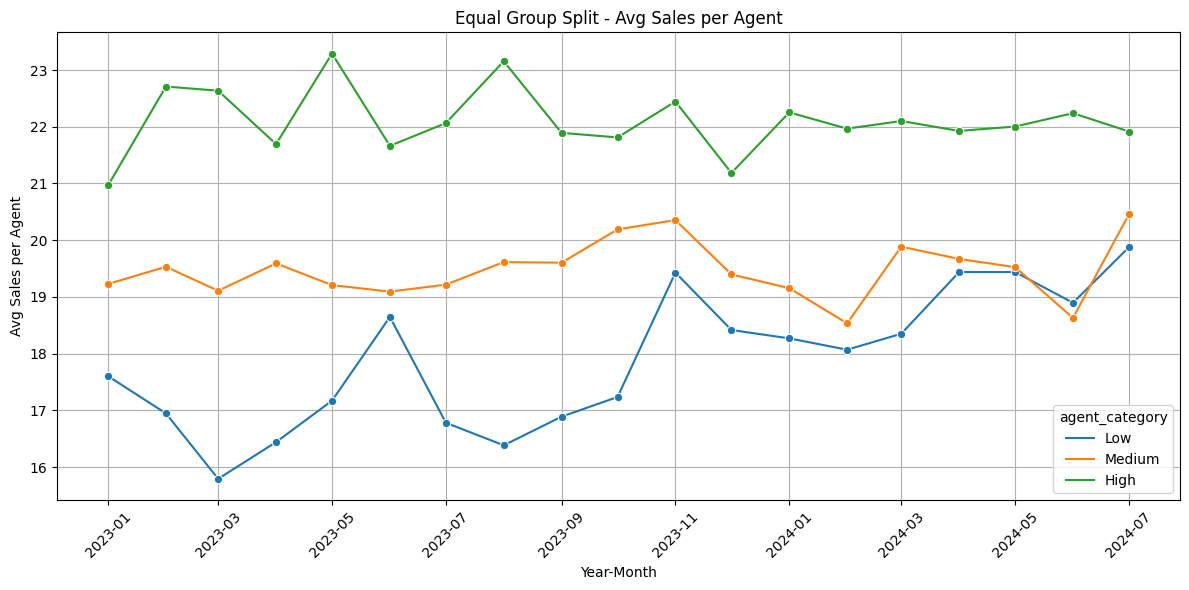

In [15]:
# Sort and split equally
agent_totals = df.groupby('agent_code')['new_policy_count'].sum().sort_values().reset_index()
agent_totals['agent_category'] = pd.qcut(agent_totals['new_policy_count'], q=3, labels=['Low', 'Medium', 'High'])

df4 = df.merge(agent_totals[['agent_code', 'agent_category']], on='agent_code')

# Plotting
filtered_df4 = df4[(df4['year_month'] >= '2023-01') & (df4['year_month'] <= '2024-07')]
monthly_sales = filtered_df4.groupby(['year_month', 'agent_category']).agg(
    total_sales=('new_policy_count', 'sum'),
    agent_count=('agent_code', 'nunique')
).reset_index()
monthly_sales['avg_sales_per_agent'] = monthly_sales['total_sales'] / monthly_sales['agent_count']

# Plot
plt.figure(figsize=(12, 6))
sns.lineplot(data=monthly_sales, x='year_month', y='avg_sales_per_agent', hue='agent_category', marker='o')
plt.title('Equal Group Split - Avg Sales per Agent')
plt.xlabel('Year-Month')
plt.ylabel('Avg Sales per Agent')
plt.xticks(rotation=45)
plt.grid(True)
plt.tight_layout()
plt.show()


In [16]:
from scipy.stats import f_oneway

for feature in ['new_policy_count', 'ANBP_value', 'net_income']:
    groups = [g[feature].dropna().values for name, g in df4.groupby('agent_category')]
    f_stat, p_val = f_oneway(*groups)
    print(f"{feature} ANOVA → F={f_stat:.2f}, p={p_val:.4f}")


new_policy_count ANOVA → F=199.70, p=0.0000
ANBP_value ANOVA → F=70.31, p=0.0000
net_income ANOVA → F=19.90, p=0.0000


/tmp/ipykernel_49/1744844108.py:4: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  groups = [g[feature].dropna().values for name, g in df4.groupby('agent_category')]


## 5. K Means Clustering Method 1

Step 1: Feature Engineering...
Step 2: Outlier Handling...
Step 3: Feature Selection...
Step 4: Scaling Features...
Step 5: Determining Optimal Clusters...


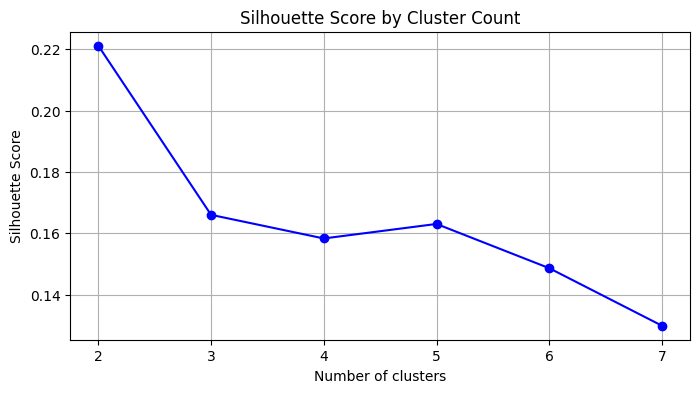

Optimal number of clusters: 2 (Silhouette Score: 0.221)
Step 6: Running Final Clustering...
Step 7: Labeling Clusters...
Step 8: Merging with Original Data...

Step 9: Running ANOVA Validation...
new_policy_count     ANOVA → F=125.11, p=0.0000
ANBP_value           ANOVA → F=243.51, p=0.0000
net_income           ANOVA → F=207.87, p=0.0000

Step 10: Cluster Profiles:
                new_policy_count_sum  sales_per_month  ANBP_value_mean  \
agent_category                                                           
High                      434.376106        22.147862     1.207144e+06   
Medium                    353.535897        19.705740     8.720383e+05   
Low                       301.635593        19.700244     1.115519e+06   

                net_income_mean  unique_customers_mean  income_per_policy  
agent_category                                                             
High              257775.630691              15.585465       11678.972456  
Medium            195370.208366  

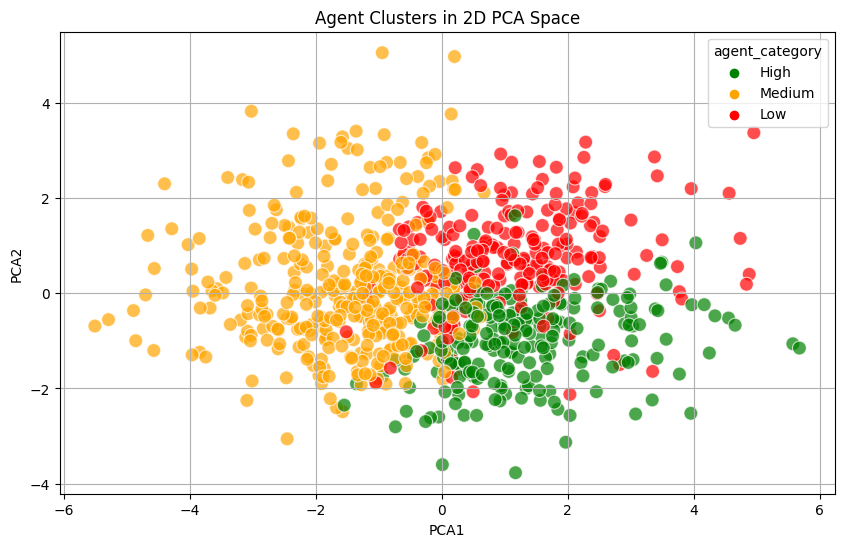

/usr/local/lib/python3.11/dist-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/usr/local/lib/python3.11/dist-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


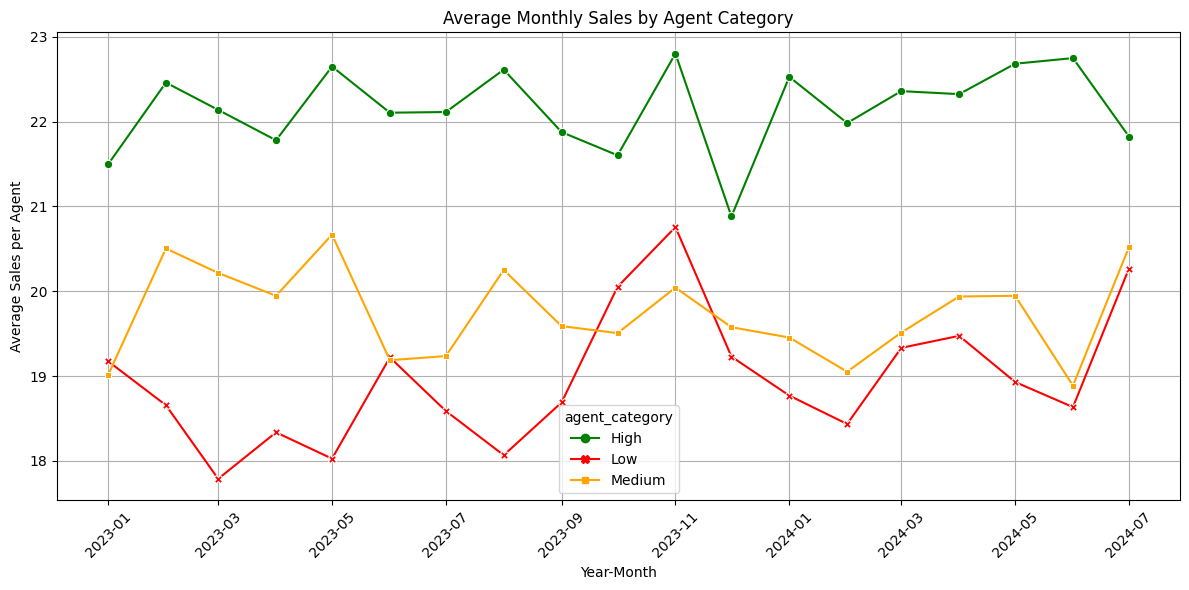

In [17]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans, AgglomerativeClustering
from sklearn.metrics import silhouette_score
from sklearn.decomposition import PCA
from scipy.stats import f_oneway

# Load your dataframe (replace with your actual data loading)
# df = pd.read_csv('your_data.csv') 

def advanced_clustering_analysis(df):
    """Complete implementation of Method 6 with visualization and validation"""
    
    # 1. Feature Engineering
    print("Step 1: Feature Engineering...")
    features = df.groupby('agent_code').agg({
        'new_policy_count': ['sum', 'mean', 'std'],  # Sales metrics
        'ANBP_value': ['mean', 'sum'],              # Business value
        'net_income': ['mean', 'sum'],              # Profitability
        'unique_customers': 'mean',                 # Customer reach
        'unique_proposal': 'mean',                  # Proposal activity
        'year_month': 'nunique',                    # Months active
        'months_since_join': 'max'                  # Tenure
    }).fillna(0)
    
    # Flatten multi-index columns
    features.columns = ['_'.join(col).strip() for col in features.columns.values]
    
    # Create meaningful derived features
    features['sales_per_month'] = features['new_policy_count_sum'] / features['year_month_nunique']
    features['income_per_policy'] = features['net_income_sum'] / features['new_policy_count_sum'].replace(0, 1)
    features['anbp_per_policy'] = features['ANBP_value_sum'] / features['new_policy_count_sum'].replace(0, 1)
    # Add these to your feature engineering:
    features['conversion_rate'] = features['new_policy_count_sum'] / features['unique_proposal_mean']
    features['customer_value'] = features['net_income_sum'] / features['unique_customers_mean'].replace(0,1)
    features['policy_size'] = features['ANBP_value_sum'] / features['new_policy_count_sum'].replace(0,1)
    
    # 2. Outlier Handling
    print("Step 2: Outlier Handling...")
    z_scores = np.abs((features - features.mean()) / features.std())
    features = features[(z_scores < 3).all(axis=1)].copy()
    
    # 3. Feature Selection
    print("Step 3: Feature Selection...")
    selected_features = features[[
        'new_policy_count_sum',
        'sales_per_month',
        'ANBP_value_mean',
        'net_income_mean',
        'unique_customers_mean',
        'income_per_policy',
        'anbp_per_policy'
    ]]
    
    # 4. Scaling
    print("Step 4: Scaling Features...")
    scaler = StandardScaler()
    scaled_features = scaler.fit_transform(selected_features)
    
    # 5. Determine Optimal Clusters
    print("Step 5: Determining Optimal Clusters...")
    silhouette_scores = []
    K = range(2, 8)
    
    for k in K:
        model = AgglomerativeClustering(n_clusters=k)
        labels = model.fit_predict(scaled_features)
        score = silhouette_score(scaled_features, labels)
        silhouette_scores.append(score)
    
    # Plot silhouette scores
    plt.figure(figsize=(8, 4))
    plt.plot(K, silhouette_scores, 'bo-')
    plt.xlabel('Number of clusters')
    plt.ylabel('Silhouette Score')
    plt.title('Silhouette Score by Cluster Count')
    plt.grid(True)
    plt.show()
    
    best_k = K[np.argmax(silhouette_scores)]
    print(f"Optimal number of clusters: {best_k} (Silhouette Score: {max(silhouette_scores):.3f})")
    
    # 6. Final Clustering
    print("Step 6: Running Final Clustering...")
    final_model = AgglomerativeClustering(n_clusters=3)  # Using 3 for High/Medium/Low
    features['cluster'] = final_model.fit_predict(scaled_features)
    
    # 7. Label Clusters by Performance
    print("Step 7: Labeling Clusters...")
    # Order clusters by sales performance
    cluster_order = features.groupby('cluster')['new_policy_count_sum'].mean().sort_values(ascending=False).index
    label_map = {cluster_order[0]: 'High', 
                 cluster_order[1]: 'Medium', 
                 cluster_order[2]: 'Low'}
    features['agent_category'] = features['cluster'].map(label_map)
    
    # 8. Merge Back with Original Data
    print("Step 8: Merging with Original Data...")
    agent_categories = features[['agent_category']].reset_index()
    df6 = df.merge(agent_categories, on='agent_code')
    
    # 9. ANOVA Validation
    print("\nStep 9: Running ANOVA Validation...")
    for feature in ['new_policy_count', 'ANBP_value', 'net_income']:
        groups = [g[feature].dropna().values for name, g in df6.groupby('agent_category')]
        f_stat, p_val = f_oneway(*groups)
        print(f"{feature.ljust(20)} ANOVA → F={f_stat:.2f}, p={p_val:.4f}")
    
    # 10. Cluster Profiling
    print("\nStep 10: Cluster Profiles:")
    profile_features = [
        'new_policy_count_sum', 'sales_per_month',
        'ANBP_value_mean', 'net_income_mean',
        'unique_customers_mean', 'income_per_policy'
    ]
    cluster_profiles = features.groupby('agent_category')[profile_features].mean()
    print(cluster_profiles.sort_values('new_policy_count_sum', ascending=False))
    
    # 11. Visualization
    print("\nStep 11: Creating Visualizations...")
    
    # PCA for Visualization
    pca = PCA(n_components=2)
    pca_features = pca.fit_transform(scaled_features)
    features['PCA1'] = pca_features[:, 0]
    features['PCA2'] = pca_features[:, 1]
    
    plt.figure(figsize=(10, 6))
    sns.scatterplot(data=features, x='PCA1', y='PCA2', hue='agent_category', 
                    palette={'High':'green', 'Medium':'orange', 'Low':'red'}, 
                    s=100, alpha=0.7)
    plt.title('Agent Clusters in 2D PCA Space')
    plt.grid(True)
    plt.show()
    
    # Time Series Performance Plot
    plt.figure(figsize=(12, 6))
    time_df = df6[(df6['year_month'] >= '2023-01') & 
                      (df6['year_month'] <= '2024-07')]
    
    monthly_stats = time_df.groupby(['year_month', 'agent_category']).agg({
        'new_policy_count': 'sum',
        'agent_code': 'nunique'
    }).reset_index()
    monthly_stats['avg_sales'] = monthly_stats['new_policy_count'] / monthly_stats['agent_code']
    
    sns.lineplot(data=monthly_stats, x='year_month', y='avg_sales', 
                 hue='agent_category', style='agent_category',
                 markers=True, dashes=False, 
                 palette={'High':'green', 'Medium':'orange', 'Low':'red'})
    plt.title('Average Monthly Sales by Agent Category')
    plt.xlabel('Year-Month')
    plt.ylabel('Average Sales per Agent')
    plt.xticks(rotation=45)
    plt.grid(True)
    plt.tight_layout()
    plt.show()
    
    return df6, features

# Execute the analysis
df6, cluster_features = advanced_clustering_analysis(df)


## 6. K means clustering - Method 2

1. Feature Engineering...

2. Data Preprocessing...

3. Determining Optimal Clusters...


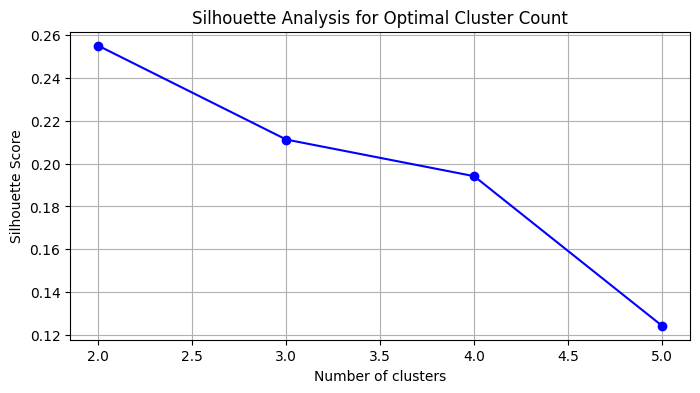

Selected clusters: 3

4. Running Final Clustering...

5. Statistical Validation...

ANOVA Results:
new_policy_count   F=102.16, p=0.0000
ANBP_value         F=192.40, p=0.0000
net_income         F=198.54, p=0.0000

Tukey HSD Post-hoc Tests:

Feature: new_policy_count
Multiple Comparison of Means - Tukey HSD, FWER=0.05 
group1 group2 meandiff p-adj   lower   upper  reject
----------------------------------------------------
  High    Low  -2.9238    0.0 -3.4947 -2.3528   True
  High Medium  -2.3216    0.0  -2.752 -1.8912   True
   Low Medium   0.6022 0.0183   0.082  1.1224   True
----------------------------------------------------

Feature: ANBP_value
       Multiple Comparison of Means - Tukey HSD, FWER=0.05        
group1 group2   meandiff   p-adj     lower        upper     reject
------------------------------------------------------------------
  High    Low  -86159.2956 0.0001 -133966.4012  -38352.1901   True
  High Medium -288582.8394    0.0 -324617.8793 -252547.7995   True
   Low

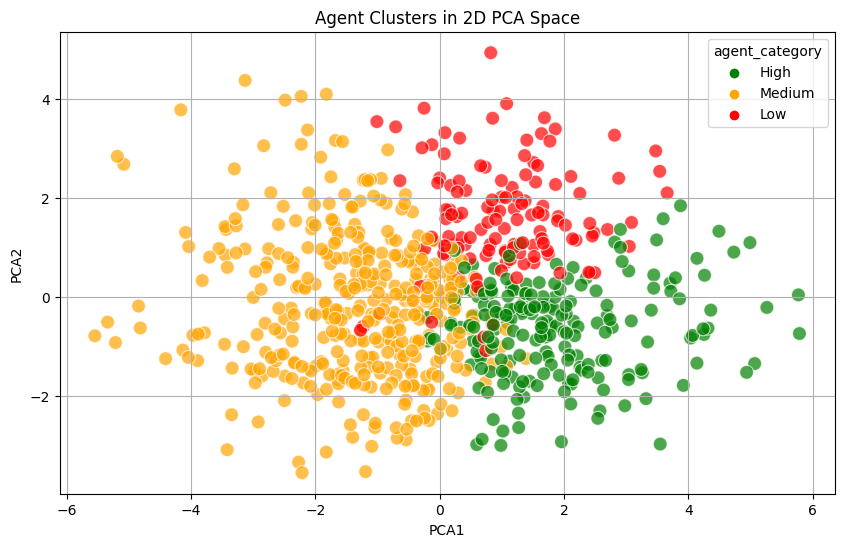

/usr/local/lib/python3.11/dist-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/usr/local/lib/python3.11/dist-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


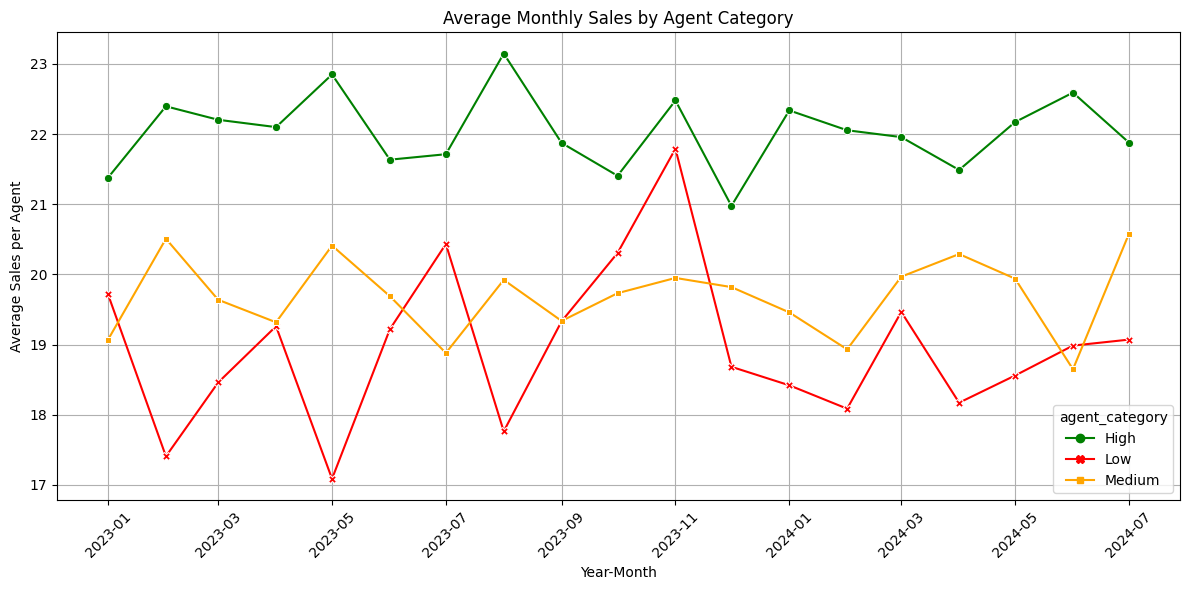

In [18]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import AgglomerativeClustering
from sklearn.metrics import silhouette_score
from sklearn.decomposition import PCA
from scipy.stats import f_oneway
from statsmodels.stats.multicomp import pairwise_tukeyhsd

def advanced_agent_clustering(df):
    """Complete implementation of Method 6 with all enhancements"""
    
    # ======================
    # 1. Feature Engineering
    # ======================
    print("1. Feature Engineering...")
    
    # Base features
    features = df.groupby('agent_code').agg({
        'new_policy_count': ['sum', 'mean', 'std'],
        'ANBP_value': ['sum', 'mean'],
        'net_income': ['sum', 'mean'],
        'unique_customers': ['mean', 'sum'],
        'unique_proposal': ['mean', 'sum'],
        'unique_quotations': ['mean', 'sum'],
        'year_month': 'nunique',
        'months_since_join': 'max'
    }).fillna(0)
    
    # Flatten multi-index columns
    features.columns = ['_'.join(col).strip() for col in features.columns.values]
    
    # Derived features
    features['conversion_rate'] = features['new_policy_count_sum'] / features['unique_proposal_sum'].replace(0, 1)
    features['customer_value'] = features['net_income_sum'] / features['unique_customers_sum'].replace(0, 1)
    features['policy_size'] = features['ANBP_value_sum'] / features['new_policy_count_sum'].replace(0, 1)
    features['sales_per_month'] = features['new_policy_count_sum'] / features['year_month_nunique']
    features['activity_level'] = features['unique_proposal_mean'] / features['unique_customers_mean'].replace(0, 1)
    
    # =====================
    # 2. Data Preprocessing
    # =====================
    print("\n2. Data Preprocessing...")
    
    # Fix: Corrected outlier handling syntax
    Q1 = features.quantile(0.25)
    Q3 = features.quantile(0.75)
    IQR = Q3 - Q1
    mask = ~((features < (Q1 - 1.5 * IQR)) | (features > (Q3 + 1.5 * IQR))).any(axis=1)
    features = features[mask]
    
    # Feature selection
    selected_features = features[[
        'new_policy_count_sum',
        'sales_per_month',
        'ANBP_value_mean',
        'net_income_mean',
        'conversion_rate',
        'customer_value',
        'policy_size'
    ]]
    
    # Scaling
    scaler = StandardScaler()
    scaled_features = scaler.fit_transform(selected_features)
    
    # ===========================
    # 3. Clustering Optimization
    # ===========================
    print("\n3. Determining Optimal Clusters...")
    
    # Silhouette analysis
    silhouette_scores = []
    K = range(2, 6)
    
    for k in K:
        model = AgglomerativeClustering(n_clusters=k)
        labels = model.fit_predict(scaled_features)
        score = silhouette_score(scaled_features, labels)
        silhouette_scores.append(score)
    
    # Plot silhouette scores
    plt.figure(figsize=(8, 4))
    plt.plot(K, silhouette_scores, 'bo-')
    plt.xlabel('Number of clusters')
    plt.ylabel('Silhouette Score')
    plt.title('Silhouette Analysis for Optimal Cluster Count')
    plt.grid(True)
    plt.show()
    
    best_k = 3  # Based on business need for High/Medium/Low
    print(f"Selected clusters: {best_k}")
    
    # ======================
    # 4. Final Clustering
    # ======================
    print("\n4. Running Final Clustering...")
    model = AgglomerativeClustering(n_clusters=best_k)
    features['cluster'] = model.fit_predict(scaled_features)
    
    # Label clusters by performance
    cluster_order = features.groupby('cluster')['new_policy_count_sum'].mean().sort_values(ascending=False).index
    label_map = {cluster_order[i]: label for i, label in enumerate(['High', 'Medium', 'Low'])}
    features['agent_category'] = features['cluster'].map(label_map)
    
    # Merge back with original data - using df7 as requested
    agent_categories = features[['agent_category']].reset_index()
    df7 = df.merge(agent_categories, on='agent_code')
    
    # ======================
    # 5. Statistical Validation
    # ======================
    print("\n5. Statistical Validation...")
    
    # ANOVA Tests
    print("\nANOVA Results:")
    for feature in ['new_policy_count', 'ANBP_value', 'net_income']:
        groups = [df7[df7['agent_category'] == cat][feature] 
                 for cat in ['High', 'Medium', 'Low']]
        f_stat, p_val = f_oneway(*groups)
        print(f"{feature.ljust(18)} F={f_stat:.2f}, p={p_val:.4f}")
    
    # Tukey HSD Post-hoc Tests
    print("\nTukey HSD Post-hoc Tests:")
    for feature in ['new_policy_count', 'ANBP_value', 'net_income']:
        print(f"\nFeature: {feature}")
        res = pairwise_tukeyhsd(
            endog=df7[feature],
            groups=df7['agent_category'],
            alpha=0.05
        )
        print(res.summary())
    
    # ======================
    # 6. Cluster Profiling
    # ======================
    print("\n6. Cluster Profiling...")
    
    profile_features = [
        'new_policy_count_sum',
        'sales_per_month',
        'ANBP_value_mean',
        'net_income_mean',
        'conversion_rate',
        'customer_value',
        'policy_size'
    ]
    
    cluster_profiles = features.groupby('agent_category')[profile_features].mean()
    cluster_profiles_normalized = (cluster_profiles - cluster_profiles.mean()) / cluster_profiles.std()
    
    print("\nCluster Profiles (Raw Values):")
    print(cluster_profiles)
    
    print("\nCluster Profiles (Normalized):")
    print(cluster_profiles_normalized)
    
    # ======================
    # 7. Visualization
    # ======================
    print("\n7. Creating Visualizations...")
    
    # PCA Visualization
    pca = PCA(n_components=2)
    pca_features = pca.fit_transform(scaled_features)
    features['PCA1'] = pca_features[:, 0]
    features['PCA2'] = pca_features[:, 1]
    
    plt.figure(figsize=(10, 6))
    sns.scatterplot(data=features, x='PCA1', y='PCA2', hue='agent_category',
                    palette={'High': 'green', 'Medium': 'orange', 'Low': 'red'},
                    s=100, alpha=0.7)
    plt.title('Agent Clusters in 2D PCA Space')
    plt.grid(True)
    plt.show()
    
    # Time Series Performance
    plt.figure(figsize=(12, 6))
    time_df = df7[(df7['year_month'] >= '2023-01') & 
                 (df7['year_month'] <= '2024-07')]
    
    monthly_stats = time_df.groupby(['year_month', 'agent_category']).agg({
        'new_policy_count': 'sum',
        'agent_code': 'nunique'
    }).reset_index()
    monthly_stats['avg_sales'] = monthly_stats['new_policy_count'] / monthly_stats['agent_code']
    
    sns.lineplot(data=monthly_stats, x='year_month', y='avg_sales', 
                 hue='agent_category', style='agent_category',
                 markers=True, dashes=False,
                 palette={'High': 'green', 'Medium': 'orange', 'Low': 'red'})
    plt.title('Average Monthly Sales by Agent Category')
    plt.xlabel('Year-Month')
    plt.ylabel('Average Sales per Agent')
    plt.xticks(rotation=45)
    plt.grid(True)
    plt.tight_layout()
    plt.show()
    
    return df7, features, cluster_profiles

# Execute the analysis
df7, cluster_features, profiles = advanced_agent_clustering(df)

# Best Method for Agent Performance Categorization 
## Quantile-Based on Agent’s Average Monthly Sales

Why?
- **Fair & Accurate** – Adjusts for activity time (active months), so part-time agents aren’t unfairly penalized.
- **Strong Statistical Separation** – Highest F-scores in ANOVA for new_policy_count (354.68) and ANBP_value (115.83).
- **Simple & Interpretable** – Easier to explain to managers/agents than clustering.
- **Aligned with Business Goals** – Directly ties performance to sales productivity (per month).


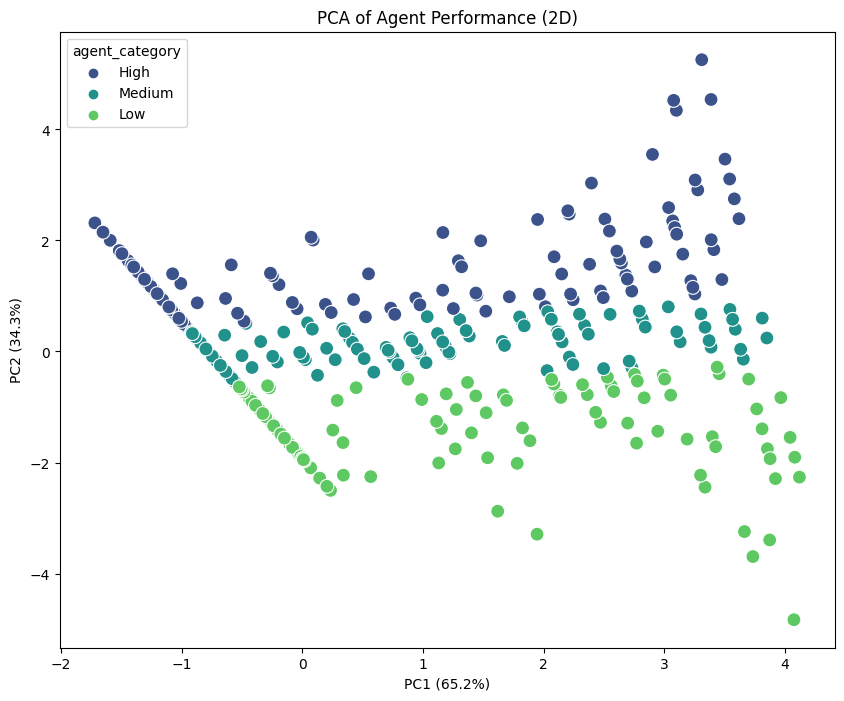

In [19]:
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler

# Prepare data for PCA
agent_stats = pd.DataFrame({
    'avg_monthly_sales': avg_monthly_sales,
    'active_months': agent_months,
    'total_sales': agent_sales
}).fillna(0)

# Standardize
scaler = StandardScaler()
scaled_data = scaler.fit_transform(agent_stats)

# PCA
pca = PCA(n_components=2)
principal_components = pca.fit_transform(scaled_data)

# Create DataFrame with proper index
pca_df = pd.DataFrame(data=principal_components,
                     columns=['PC1', 'PC2'],
                     index=agent_stats.index)

# Ensure agent_category is properly indexed
agent_category_series = pd.Series(agent_category['agent_category'].values,
                                index=agent_category['agent_code'])

# Add category to PCA df
pca_df['agent_category'] = agent_category_series.loc[pca_df.index].values

# Plotting
plt.figure(figsize=(10, 8))
sns.scatterplot(data=pca_df, x='PC1', y='PC2',
               hue='agent_category', palette='viridis', s=100)
plt.title('PCA of Agent Performance (2D)')
plt.xlabel(f'PC1 ({pca.explained_variance_ratio_[0]:.1%})')
plt.ylabel(f'PC2 ({pca.explained_variance_ratio_[1]:.1%})')
plt.show()

/usr/local/lib/python3.11/dist-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/usr/local/lib/python3.11/dist-packages/seaborn/_oldcore.py:1075: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  data_subset = grouped_data.get_group(pd_key)
/usr/local/lib/python3.11/dist-packages/seaborn/_oldcore.py:1075: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  data_subset = grouped_data.get_group(pd_key)
/usr/local/lib/python3.11/dist-packages/seaborn/_oldcore.py:1075: FutureWarning: When grouping with a length-1 list-l

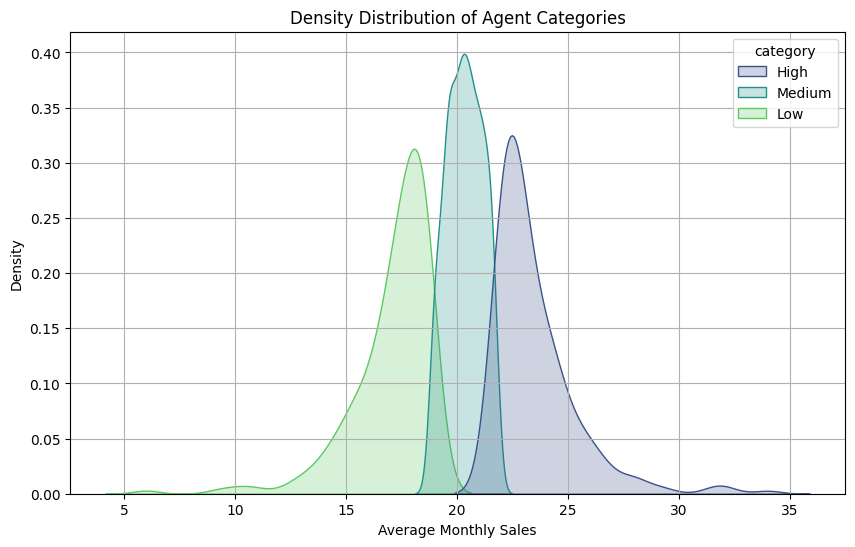

/usr/local/lib/python3.11/dist-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/usr/local/lib/python3.11/dist-packages/seaborn/_oldcore.py:1075: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  data_subset = grouped_data.get_group(pd_key)
/usr/local/lib/python3.11/dist-packages/seaborn/_oldcore.py:1075: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  data_subset = grouped_data.get_group(pd_key)
/usr/local/lib/python3.11/dist-packages/seaborn/_oldcore.py:1075: FutureWarning: When grouping with a length-1 list-l

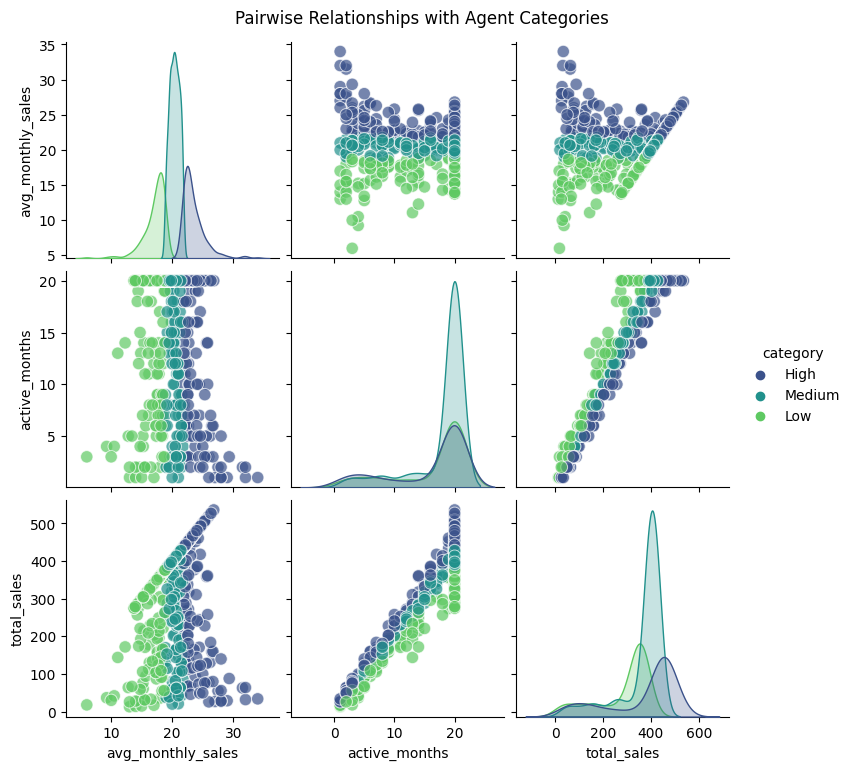

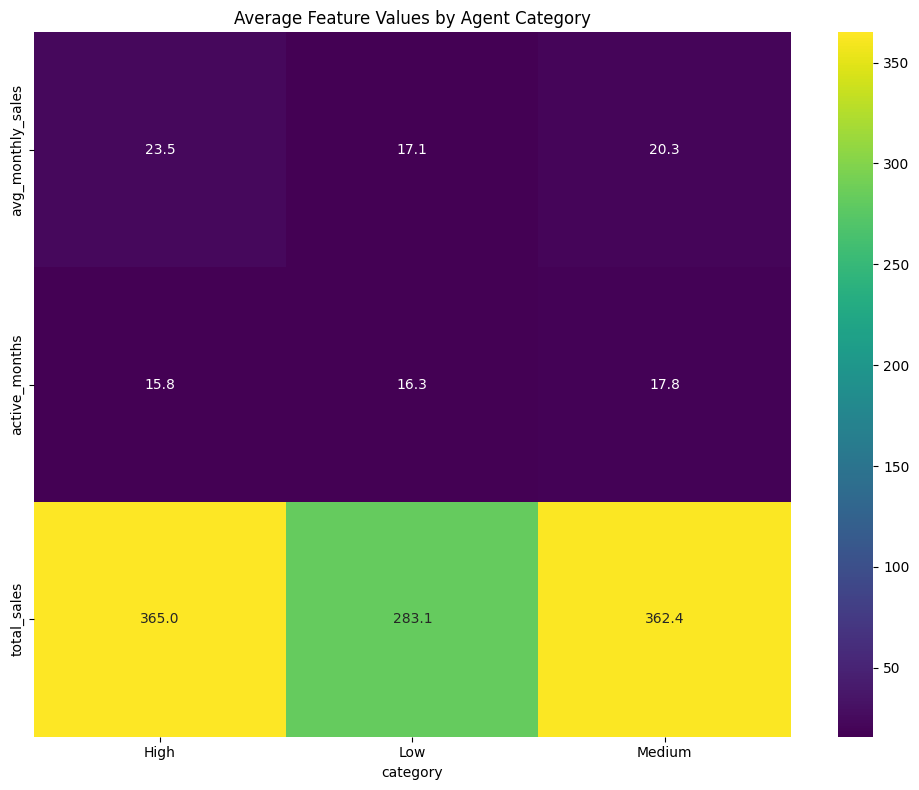

In [20]:
# First ensure agent_category is properly aligned with agent_stats
if isinstance(agent_category, pd.DataFrame):
    agent_category_series = pd.Series(agent_category['agent_category'].values, 
                                    index=agent_category['agent_code'])
    agent_stats['category'] = agent_category_series.loc[agent_stats.index].values
else:
    agent_stats['category'] = agent_category.loc[agent_stats.index].values

# 1. Fixed KDE Plot
plt.figure(figsize=(10, 6))
sns.kdeplot(data=agent_stats, x='avg_monthly_sales', hue='category', 
            palette='viridis', fill=True, common_norm=False)
plt.title('Density Distribution of Agent Categories')
plt.xlabel('Average Monthly Sales')
plt.ylabel('Density')
plt.grid(True)
plt.show()

# 2. Fixed Pair Plot
sns.pairplot(agent_stats.dropna(), hue='category', palette='viridis',
             plot_kws={'alpha': 0.7, 's': 80})
plt.suptitle('Pairwise Relationships with Agent Categories', y=1.02)
plt.show()

# 3. Fixed Heatmap
plt.figure(figsize=(10, 8))
sns.heatmap(agent_stats.groupby('category').mean().T, 
            annot=True, cmap='viridis', fmt='.1f')
plt.title('Average Feature Values by Agent Category')
plt.tight_layout()
plt.show()